In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt


In [9]:
# Đường dẫn tới các file dữ liệu
file_paths = {
    "TCB": "financial_data_TCB_filtered.csv",
    "VCB": "financial_data_VCB_filtered.csv",
    "BID": "financial_data_BID_filtered.csv",
    "MBB": "financial_data_MBB_filtered.csv",
    "GDP": "gdp_quarterly_2013_2023.csv"
}

# Đọc dữ liệu
data_tcb = pd.read_csv(file_paths["TCB"])
data_vcb = pd.read_csv(file_paths["VCB"])
data_bid = pd.read_csv(file_paths["BID"])
data_mbb = pd.read_csv(file_paths["MBB"])
data_gdp = pd.read_csv(file_paths["GDP"])

# Chuyển đổi cột Date sang định dạng datetime
data_tcb['Date'] = pd.to_datetime(data_tcb['Date'])
data_vcb['Date'] = pd.to_datetime(data_vcb['Date'])
data_bid['Date'] = pd.to_datetime(data_bid['Date'])
data_mbb['Date'] = pd.to_datetime(data_mbb['Date'])
data_gdp['Date'] = pd.to_datetime(data_gdp['Date'])

# Gộp dữ liệu GDP với dữ liệu các ngân hàng
merged_data = data_gdp.copy()
merged_data = merged_data.merge(data_tcb, on="Date", suffixes=('', '_TCB'))
merged_data = merged_data.merge(data_vcb, on="Date", suffixes=('', '_VCB'))
merged_data = merged_data.merge(data_bid, on="Date", suffixes=('', '_BID'))
merged_data = merged_data.merge(data_mbb, on="Date", suffixes=('', '_MBB'))


In [10]:
# Tạo các biến lùi từ GDP cho mô hình XGBoost
lag_features = 4  # Sử dụng 4 quý trước để dự đoán quý tiếp theo
for i in range(1, lag_features + 1):
    merged_data[f'Quarterly_GDP_lag_{i}'] = merged_data['Quarterly_GDP'].shift(i)

# Bỏ các hàng có giá trị NaN sau khi tạo biến lùi
merged_data = merged_data.dropna()

# Chọn biến đầu vào (X) và biến mục tiêu (y)
selected_features = ['roe', 'roa', 'interestMargin', 'badDebtPercentage', 'provisionOnBadDebt', 'equityOnTotalAsset']
X = merged_data[selected_features + [f'Quarterly_GDP_lag_{i}' for i in range(1, lag_features + 1)]]
y = merged_data['Quarterly_GDP']


In [11]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
# Xây dựng mô hình XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

C:\Users\Hii\AppData\Local\Temp\ipykernel_20032\3615867950.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates_forecast = pd.date_range(start=dates_train.iloc[-1] + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')


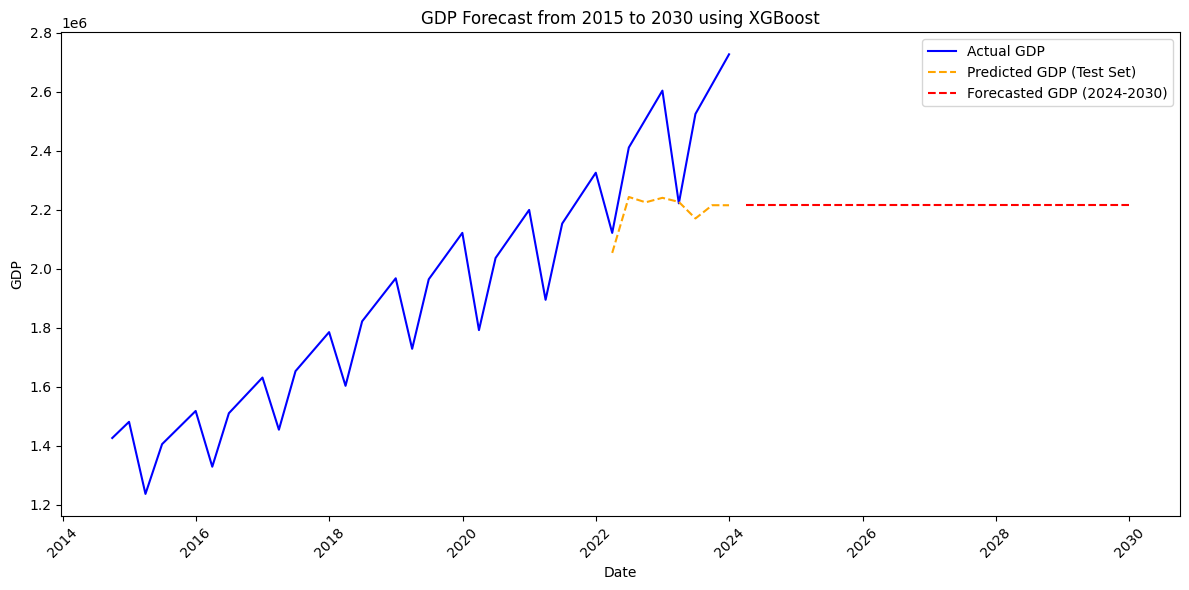

In [14]:
# Chuẩn bị dữ liệu cho dự báo từ 2024 đến 2030
forecast_steps = 24  # Dự báo 6 năm (2024 đến 2030, tính theo quý)
last_known_exog = X.iloc[-1]
future_exog = pd.DataFrame([last_known_exog] * forecast_steps, columns=X.columns)

# Dự báo GDP cho giai đoạn 2024 đến 2030
forecast_gdp = xgb_model.predict(future_exog)

# Kết hợp dữ liệu thực tế và dự báo để vẽ biểu đồ
dates_train = merged_data['Date'].iloc[len(y_train):]
dates_forecast = pd.date_range(start=dates_train.iloc[-1] + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], y, label="Actual GDP", color="blue")
plt.plot(dates_train, y_pred, label="Predicted GDP (Test Set)", color="orange", linestyle="--")
plt.plot(dates_forecast, forecast_gdp, label="Forecasted GDP (2024-2030)", color="red", linestyle="--")
plt.title("GDP Forecast from 2015 to 2030 using XGBoost")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


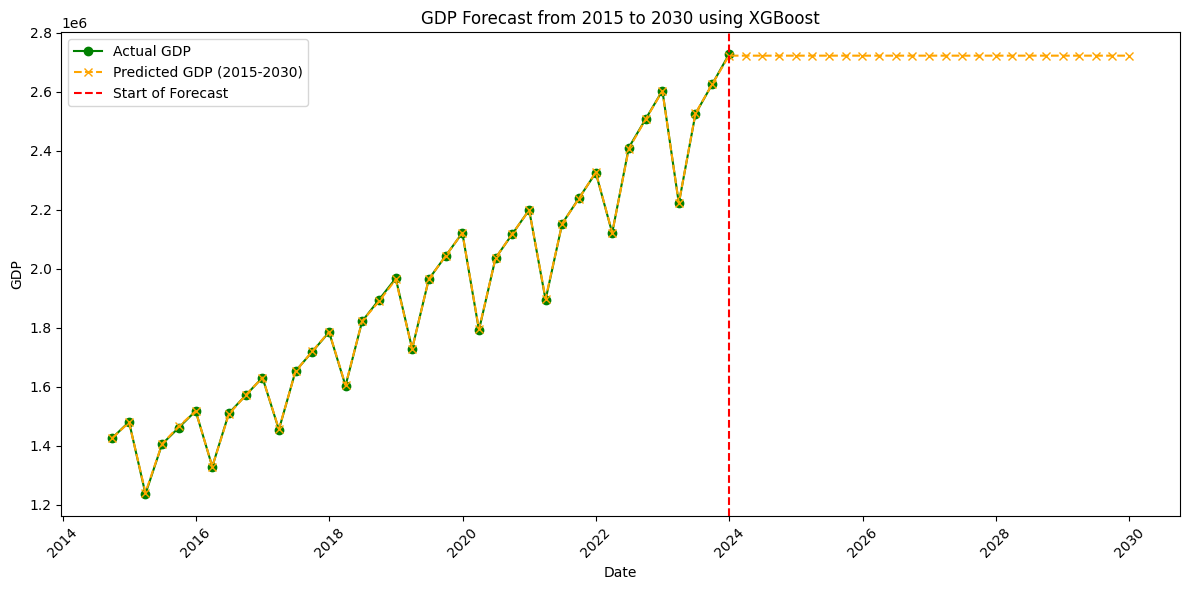

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Vẽ biểu đồ dự báo của XGBoost từ năm 2015 đến 2030
plt.figure(figsize=(12, 6))

# Vẽ GDP thực tế từ năm 2015 đến 2023
plt.plot(merged_data['Date'], y, label="Actual GDP", color="green", marker="o")

# Vẽ GDP dự báo của XGBoost từ 2015 đến 2030 với các chấm đánh dấu và màu cam
plt.plot(dates_full, predicted_gdp_full, label="Predicted GDP (2015-2030)", color="orange", linestyle="--", marker="x")

# Thêm đường dọc để đánh dấu điểm bắt đầu dự báo vào năm 2024
plt.axvline(x=pd.Timestamp('2024-01-01'), color='red', linestyle='--', label='Start of Forecast')

# Cài đặt tiêu đề và nhãn
plt.title("GDP Forecast from 2015 to 2030 using XGBoost")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# Dự báo trên tập kiểm tra
y_pred = xgb_model.predict(X_test)

# Tính MAPE và RMSE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Chuyển MAPE sang phần trăm
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


MAPE: 10.50%
RMSE: 316146.17
